LSTM MODEL TEST

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
np.random.seed(100)
# --- 1. Load and clean data ---
main_filename = '../../data/raw/all_stocks_5yr.csv'
df = pd.read_csv(main_filename)
df = df.dropna()
df['date'] = pd.to_datetime(df['date'])

In [3]:
df

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [4]:
# --- 2. Filter to one stock (e.g., AAPL) and sort by time ---
STKNAME ='AAPL'
df = df[df['Name'] == STKNAME].sort_values('date').reset_index(drop=True)

# Drop date and stock name (not needed anymore)
df = df.drop(columns=['date', 'Name'])

In [5]:
df

,open,high,low,close,volume
0,67.7142,68.4014,66.8928,67.8542,158168416
1,68.0714,69.2771,67.6071,68.5614,129029425
2,68.5014,68.9114,66.8205,66.8428,151829363
3,66.7442,67.6628,66.1742,66.7156,118721995
4,66.3599,67.3771,66.2885,66.6556,88809154
...,...,...,...,...,...
1254,167.1650,168.6200,166.7600,167.7800,47230787
1255,166.0000,166.8000,160.1000,160.5000,86593825
1256,159.1000,163.8800,156.0000,156.4900,72738522
1257,154.8300,163.7200,154.0000,163.0300,68243838


In [6]:
# --- 3. Normalize features ---
features = ['open', 'high', 'low', 'volume']  # exclude 'close' (target)
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
# Normalize 'close' too
target_scaler = MinMaxScaler()
df['close'] = target_scaler.fit_transform(df[['close']])

In [7]:
# --- 4. Create sequences (sliding window) ---
def create_sequences(data, target_col='close', window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_x = data.iloc[i:i+window_size][features].values
        seq_y = data.iloc[i+window_size][target_col]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [8]:
# --- 5. Generate sequences ---
window_size = 10
X_all, y_all = create_sequences(df, target_col='close', window_size=window_size)

In [9]:
# --- 6. Chronological train/val/test split ---
n = len(X_all)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_val, y_val     = X_all[train_end:val_end], y_all[train_end:val_end]
X_test, y_test   = X_all[val_end:], y_all[val_end:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (749, 10, 4)
y_train shape: (749,)


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# --- 1. Convert numpy arrays to PyTorch tensors ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=64, shuffle=False)

In [11]:
# --- 2. Define the LSTM model ---
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)  # out: (batch_size, seq_len, hidden_size)
        out = out[:, -1, :]    # take the last time step
        out = self.fc(out)
        return out

In [12]:
# --- 3. Initialize model, loss, optimizer ---
input_size = X_train.shape[2]
model = StockLSTM(input_size=input_size, hidden_size=64).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# --- 4. Training loop ---
epochs = 20
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        output = model(xb)
        loss = criterion(output, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            output = model(xb)
            loss = criterion(output, yb)
            val_loss += loss.item()
        val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

Epoch 1/20 | Train Loss: 0.0779 | Val Loss: 0.0496
Epoch 2/20 | Train Loss: 0.0107 | Val Loss: 0.0039
Epoch 3/20 | Train Loss: 0.0271 | Val Loss: 0.0040
Epoch 4/20 | Train Loss: 0.0149 | Val Loss: 0.0039
Epoch 5/20 | Train Loss: 0.0077 | Val Loss: 0.0009
Epoch 6/20 | Train Loss: 0.0060 | Val Loss: 0.0006
Epoch 7/20 | Train Loss: 0.0025 | Val Loss: 0.0004
Epoch 8/20 | Train Loss: 0.0011 | Val Loss: 0.0017
Epoch 9/20 | Train Loss: 0.0013 | Val Loss: 0.0005
Epoch 10/20 | Train Loss: 0.0008 | Val Loss: 0.0017
Epoch 11/20 | Train Loss: 0.0016 | Val Loss: 0.0008
Epoch 12/20 | Train Loss: 0.0014 | Val Loss: 0.0027
Epoch 13/20 | Train Loss: 0.0025 | Val Loss: 0.0011
Epoch 14/20 | Train Loss: 0.0023 | Val Loss: 0.0040
Epoch 15/20 | Train Loss: 0.0044 | Val Loss: 0.0009
Epoch 16/20 | Train Loss: 0.0037 | Val Loss: 0.0041
Epoch 17/20 | Train Loss: 0.0072 | Val Loss: 0.0005
Epoch 18/20 | Train Loss: 0.0036 | Val Loss: 0.0015
Epoch 19/20 | Train Loss: 0.0060 | Val Loss: 0.0011
Epoch 20/20 | Train L

In [14]:
# --- 5. Evaluate on test set ---
model.eval()
test_loss = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        output = model(xb)
        loss = criterion(output, yb)
        test_loss += loss.item()
    test_loss /= len(test_loader)

print(f"Test MSE Loss: {test_loss:.4f}")

Test MSE Loss: 0.0010


In [15]:
model.eval()
preds, actuals = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        output = model(xb).cpu().numpy()
        preds.extend(output)
        actuals.extend(yb.numpy())

# Convert to original scale
preds_orig = target_scaler.inverse_transform(np.array(preds))
actuals_orig = target_scaler.inverse_transform(np.array(actuals))

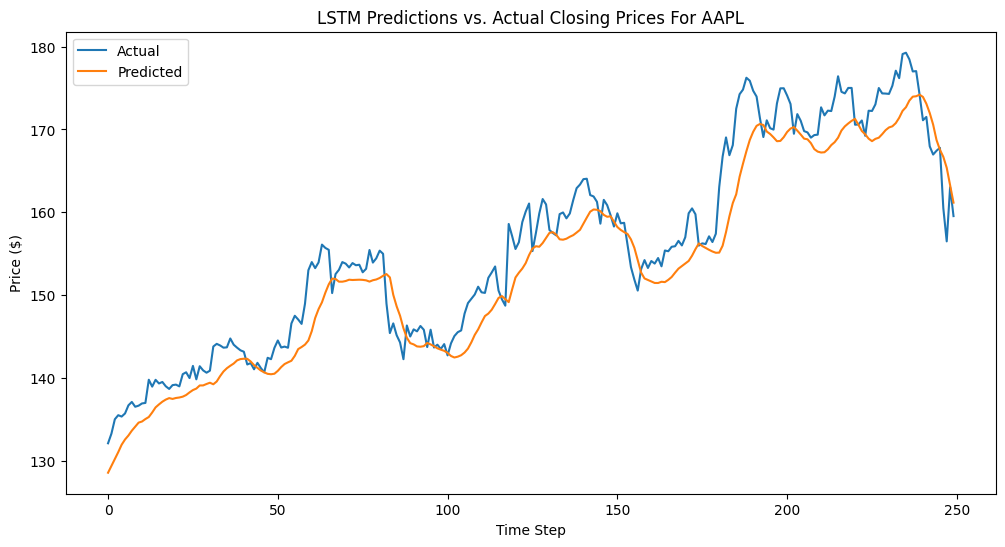

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(actuals_orig, label='Actual')
plt.plot(preds_orig, label='Predicted')
plt.title("LSTM Predictions vs. Actual Closing Prices" +" For " + STKNAME)
plt.xlabel("Time Step")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(actuals_orig, preds_orig))
print(f"Test RMSE (in original price units): ${rmse:.2f}")

Test RMSE (in original price units): $3.87
